In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, hstack
import itertools
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.metrics import coverage_error
from sklearn.svm import SVC
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.neural_network import MLPClassifier
import scipy.sparse
from sklearn.metrics import f1_score

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup

#from sklearn.preprocessing import StandardScaler

from scipy.sparse import coo_matrix, hstack


In [3]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

# Dataset preparation

In [4]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [5]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [6]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [7]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

In [8]:
dataset.head()

,TText,TText_NEG,PText,TCode,PCode,TTitle,TTitle_NEG,Title,PTags,Tags
Id,,,,,,,,,,
48106373,tri design cdf chart use chartj show probabl g...,tri design cdf chart use chartj show probabl g...,I am trying to design a CDF Chart using chart...,None,None,custom gridlin axe chartj,custom gridlin axe chartj,Custom gridLines and Axes Chartjs,"['javascript', 'charts', 'chart.js']",<javascript><charts><chart.js>
48094941,current work task sync file insid azur file-st...,current work task sync file insid azur file-st...,"Currently, I work on a task to sync files ins...",None,None,notif chang azur storag,notif chang azur storag,Notification about changes in azure storage,"['azure', 'azure-storage']",<azure><azure-storage>
48135853,'m build io calcul app thing 'm stuck display ...,'m build io calcul app thing 'm stuck display ...,I'm building iOS calculator app. Thing I'm st...,import UIKit enum Action : Int { case minus = ...,import UIKit\n\nenum Action: Int {\ncase minus...,display result oper press oper,display result oper press oper,Displaying result of operation after pressing ...,"['ios', 'swift', 'calculator']",<ios><swift><calculator>
48103099,'m tri instal program mac os x tri run code ge...,'m tri instal program mac os x tri run code ge...,I'm trying to install a program on a mac os x...,chmod + x linkmac - bash : chmod : command not,chmod +x linkmac\n -bash: chmod: command not f...,chmod command found,chmod command found_NEG,chmod command not found,"['macos', 'chmod']",<macos><chmod>
48107196,understand http2 use one tcp connect serv mult...,understand http2 use one tcp connect serv mult...,I understand that http2 use one tcp connectio...,None,None,doe http2 tcp connect close,doe http2 tcp connect close,When does a http2 TCP connection close?,"['web', 'tcp', 'http2']",<web><tcp><http2>


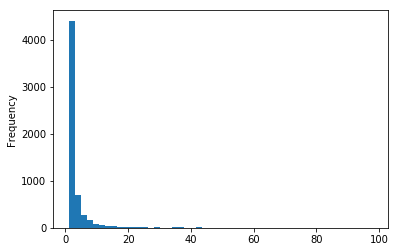

In [9]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()




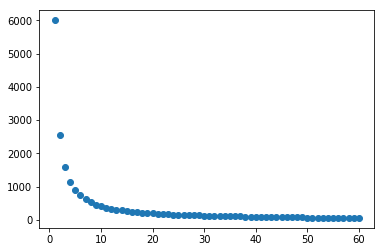

In [10]:
#Sample size according tag popularity
x=range(1,61)
y=[]
for numtag in x:
    y.append(df[df>=numtag].shape[0])
plt.scatter(x,y)

plt.show()

In [11]:
popularitytags = df[df>50].to_dict()
len(popularitytags)

71

In [12]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(7966, 12)


,PTagsCleaned,PTags,TCode
Id,,,
48106373,[javascript],"[javascript, charts, chart.js]",None
48094941,[azure],"[azure, azure-storage]",None
48135853,"[ios, swift]","[ios, swift, calculator]",import UIKit enum Action : Int { case minus = ...
48103099,[macos],"[macos, chmod]",chmod + x linkmac - bash : chmod : command not
48174907,"[html, css]","[html, css]",. prev { cursor : pointer ; position : absolut...


In [13]:
popularitytags['r']

188

http://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification-format

# Dataset preparation

In [14]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [15]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(7966, 71)

In [16]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

# Custom TFidf  function

In [17]:
#Custom TfIDF creation

class Customtfidf(BaseEstimator, TransformerMixin):

    def __init__(self, **params):
        
        self.params={
            'text_max_features':None, 'title_max_features':None, 'code_max_features':None,
            'text_min_df':1, 'title_min_df':1, 'code_min_df':1,
            'text_max_df':1., 'title_max_df':1., 'code_max_df':1.,
            'text_ngram_range':(1,1), 'title_ngram_range':(1,1), 'code_ngram_range':(1,1),
                    }
        self.params = {**self.params, **params}
        
        self.textparams = {}
        self.titleparams = {}
        self.codeparams = {}
        
        self.update_params()
        
    

    def fit(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        
        self.update_params()
        
        #Text preparation
        self.texttfidf = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.textparams)
        self.texttfidf.fit(dftext)
        
        #Title preparation
        self.titletfidf = CountVectorizer(tokenizer=None, vocabulary=None, **self.titleparams)
        self.titletfidf.fit(dftitle)

        
        #Code preparation
        self.codetfidf = CountVectorizer(tokenizer=None, vocabulary=None, **self.codeparams)
        self.codetfidf.fit(dfcode)
        return self
    
    def transform(self, X, y=None):
        dftext = X['TText']
        dftitle = X['TTitle']
        dfcode = X['TCode']
        
        #Text preparation
        texttfidf = self.texttfidf.transform(dftext)
        
        #Title preparation
        titletfidf = self.titletfidf.transform(dftitle)
    
        #Code preparation
        codetfidf = self.codetfidf.transform(dfcode)
        
        return scipy.sparse.hstack((texttfidf, titletfidf, codetfidf), format='csr')
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        #print({**params})
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        self.textparams = {k[5:]:v for k,v in self.params.items() if k.startswith('text')}
        self.titleparams = {k[6:]:v for k,v in self.params.items() if k.startswith('title')}
        self.codeparams = {k[5:]:v for k,v in self.params.items() if k.startswith('code')}
        return self
    


customtfidf = Customtfidf()
#Customtfidf.fit(textset[['TText', 'TTitle', 'TCode']])
#print('Step1 done')
#XX = customtfidf.fit_transform(X_train)#.shape

# Randomforrest version

In [236]:
class Customtclf(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.clf = RandomForestClassifier(random_state=0)
        self.params = {**{'limit':.15}, **kwargs}
        
        self.clfparams={**self.params}
        self.clfparams.pop('limit')
        self.limit=self.params['limit']
        
        self.clf.set_params(**self.clfparams)
    
    def fit(self, X, y):
        self.clf = RandomForestClassifier(random_state=0)
        self.clf.set_params(**self.clfparams)
        self.clf.fit(X, y)
        return self
    
    def predict(self, X):
        probas = self.clf.predict_proba(X)
        lines = []
        for proba in probas:
            newproba = np.where(proba[:,1] >= self.params['limit'] , 1, 0)
            lines.append(newproba.reshape(-1,1))
        return np.concatenate(lines, axis=1)
    
    def predict_proba(self, X, y=None):
        probas = self.clf.predict_proba(X)
        lines = []
        for proba in probas:
            newproba = np.where(proba[:,1] >= self.params['limit'] , proba[:,1], proba[:,0])
            lines.append(newproba.reshape(-1,1))
        return np.concatenate(lines, axis=1)
        

    def set_params(self, **params):
        self.params = {**self.params, **params}
        
        self.clfparams={**self.params}
        self.clfparams.pop('limit')
        #print(self.clfparams)
        self.limit=self.params['limit']
        return self
        
    def get_params(self, deep=True):
        return self.params
    
    def score(self, X, y):
        return self.clf.score(X, y)

customclf = Customtclf()
#XX=customtfidf.fit_transform(X_train)
    
#rmf = RandomForestClassifier(random_state=0)
#customclf = Customtclf()
#customclf.fit(XX, y_train)
        
        
    

In [259]:
#Metrics creation

#from sklearn.metrics import fbeta_score
#scorer = make_scorer(fbeta_score, beta=0.5, average = 'micro')
#scorer = make_scorer(jaccard_similarity_score)
#scorer = make_scorer(f1_score, average='micro')
scorer = make_scorer(label_ranking_average_precision_score, needs_proba=True)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}


In [290]:
#Gridsearch creation Step1
#Pipeline creation
pipe = [('customtfidf', Customtfidf()), 
        ('customclf', Customtclf(limit=0.15, n_estimators=30))
       ]
kpipeline = Pipeline(pipe)

parameters1 = {
              'customtfidf__text_max_features':[20000, 15000, 25000],
              'customtfidf__text_max_df':[1.,.95],
              'customtfidf__text_min_df':[1, 10, 20],
              'customtfidf__text_ngram_range':[(1,1), (1,2), (1,3)],
              'customclf__limit':[.2,.4, .3],
              #'customclf__min_samples_split':[2,10,20],
              ##'customclf__min_samples_leaf':[1,3,5],
              }

clf1 = GridSearchCV(kpipeline, parameters1, verbose = 3, cv = 2, n_jobs=3, return_train_score=True, scoring=scorer)
clf1.fit(X_train, y_train)

Fitting 2 folds for each of 162 candidates, totalling 324 fits
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.48472785239300187, total=   7.9s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=2

[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.4870472971467965, total=   8.6s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3), score=0.4779167996871789, total=   9.3s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.47693532480516515, total=   7.0s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfid

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.5min


[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.47737278112051945, total=   7.8s
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.48702007434299655, total=   7.8s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.46828509328759266, total=   8.4s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customt

[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.467312960776883, total=   6.9s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.4600194766787127, total=   7.6s
[CV] customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__

[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.48472785239300187, total=   7.4s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.47469532114246127, total=   8.3s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.48095489552629717, total=   7.4s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, custo

[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3), score=0.47777196199695915, total=   9.7s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.47693532480516515, total=   7.0s
[CV] customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, custo

[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.3221034627406339, total=   7.8s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.3250050114706904, total=   7.7s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.3103303116021022, total=   8.5s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfid

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  6.7min


[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.3005060966706417, total=   7.6s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.30896199449108513, total=   7.6s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.313690533641189, total=   8.3s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf

[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.3122553350508356, total=   7.3s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.30628512669739416, total=   9.3s
[CV] customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__tex

[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.31951429568418616, total=   7.0s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.3037814949278876, total=   6.9s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3), score=0.3085553847943222, total=   9.5s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, cust

[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.3103303116021022, total=   8.5s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.31381186072812634, total=   7.1s
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.3119176485436947, total=   8.7s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, cus

[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.3005060966706417, total=   7.7s
[CV] customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2), score=0.30896199449108513, total=   7.6s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.313690533641189, total=   8.3s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customt

[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.41932751012811165, total=   7.4s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.4292712269812546, total=   8.6s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__tex

[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 1), score=0.42062560477932565, total=   7.0s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3), score=0.4365168546277439, total=   9.9s
[CV] customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf_

[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.40401786929588557, total=   8.6s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.41015651874784087, total=   7.1s


[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 15.5min


[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.4252031192383469, total=   8.7s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.4091111012119005, total=   6.9s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, custom

[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.4179949229470825, total=   8.5s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.4204129266246354, total=   7.4s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.40628203319696293, total=   8.3s
[CV] customclf__limit=0.3, customtfidf__text_max_df=0.95, custom

[Parallel(n_jobs=3)]: Done 324 out of 324 | elapsed: 17.8min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), text_max_df=1.0, text_max_features=None,
      text_min_df=1, text_ngram_range=(1, 1), title_max_df=1.0,
      title_max_features=None, title_min_df=1, title_ngram_range=(1, 1))), ('customclf', Customtclf(limit=0.15, n_estimators=30))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__text_max_features': [20000, 15000, 25000], 'customtfidf__text_max_df': [1.0, 0.95], 'customtfidf__text_min_df': [1, 10, 20], 'customtfidf__text_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customclf__limit': [0.2, 0.4, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [291]:
f1_score(y_test, clf1.predict(X_test), average='micro')

0.62055807297877419

In [292]:
clf1.score(X_test, y_test)

0.51214883724434723

In [293]:
clf1.best_params_

{'customclf__limit': 0.2,
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 10,
 'customtfidf__text_ngram_range': (1, 1)}

In [294]:
#Gridsearch creation Step2

init1 = clf1.best_params_
init1 = {k:v for k,v in init1.items() if k.startswith('customtfidf')}

pipe = [('customtfidf', Customtfidf(**init1)), 
        ('customclf', Customtclf(limit=0.15, n_estimators=30))
       ]
kpipeline = Pipeline(pipe)

parameters2 = {
              'customtfidf__title_max_features':[5000, 6000, 4000],
              'customtfidf__title_max_df':[1.,.95],
              'customtfidf__title_min_df':[1, 10, 20],
              'customtfidf__title_ngram_range':[(1,1), (1,2), (1,3)],
              'customclf__limit':[.2,.4],
              #'customclf__min_samples_split':[2,5],
              #'customclf__min_samples_leaf':[1,5],
              }

clf2 = GridSearchCV(kpipeline, parameters2, verbose = 3, cv = 3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf2.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.4869381777332089, total=   9.2s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.4896445034572552, total=   9.2s
[CV]  customclf__limit=0.2, customt

[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.4848939253914648, total=   9.2s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.4828571017655538, total=   9.3s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.47689059714794396, total=   9.3s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__title_max_d

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.7min


[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.4896445034572552, total=   9.3s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.5049520845627617, total=   9.4s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.4869381777332089, total=   9.4s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0,

[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.47689059714794396, total=   9.3s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.4828571017655538, total=   9.3s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6

[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.49535269436185775, total=   9.0s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.48110082098331913, total=   9.0s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.4835886437908437, total=   9.0s
[CV] customclf__limit=0.2, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__title_max_

[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.4930819535840026, total=   8.7s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.48285204991086783, total=   8.7s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.49837886413319266, total=   9.1s
[CV]  customclf__limit=0.2, customtfidf__titl

[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.4934438710180214, total=   8.8s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.48637983697266235, total=   8.7s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.49271827318850603, total=   8.7s
[CV] customclf__limit=0.2, customtfidf__title

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.8min


[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.49837886413319266, total=   8.9s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.4930819535840026, total=   8.8s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_featu

[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.4934438710180214, total=   8.8s
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.48637983697266235, total=   8.7s
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__title_max_df=0.95, customtfidf__title_max_feat

[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.3460504864824648, total=   9.0s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.3408326930999467, total=   9.1s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.34007350621489607, total=   9.2s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.

[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.32542617274052577, total=   8.9s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.3344250704256647, total=   8.9s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.3209630310457448, total=   8.9s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0

[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.3123136697860895, total=   8.7s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.31959810045539366, total=   8.9s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=6

[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.32922990131126495, total=   8.6s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.3172369383111873, total=   8.7s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.32196654040403344, total=   8.7s
[CV] customclf__limit=0.4, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__title_max_

[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.3059146613190664, total=   8.9s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.3378078223528594, total=   9.0s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_featu

[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.33598696150804863, total=   8.8s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.3202603244591347, total=   8.9s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_feat

[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 17.7min


[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.3363668333129127, total=   9.3s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.3378078223528594, total=   9.2s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=6000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_featu

[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.34547197262398466, total=   9.3s
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.32743993241235214, total=   9.2s
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV] customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__title_max_df=0.95, customtfidf__title_max_featu

[Parallel(n_jobs=3)]: Done 324 out of 324 | elapsed: 20.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
      customtfidf__text_max_features=20000, customtfidf__text_min_df=10,
      customtfidf__text_ngram_range=(1, 1), text_max_df=1.0,
      text_max..._min_df=1,
      title_ngram_range=(1, 1))), ('customclf', Customtclf(limit=0.15, n_estimators=30))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__title_max_features': [5000, 6000, 4000], 'customtfidf__title_max_df': [1.0, 0.95], 'customtfidf__title_min_df': [1, 10, 20], 'customtfidf__title_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customclf__limit': [0.2, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [295]:
clf2.score(X_test, y_test)

0.51375823901171491

In [296]:
f1_score(y_test, clf2.predict(X_test), average='micro')

0.62088766598875456

In [297]:
clf2.best_params_

{'customclf__limit': 0.2,
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 4000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 3)}

In [298]:
#Gridsearch creation Step3

init2 = clf2.best_params_
init2 = {k:v for k,v in init2.items() if k.startswith('customtfidf')}
init2 = {**init2, **init1}

pipe = [('customtfidf', Customtfidf(**init2)), 
        ('customclf', Customtclf(limit=0.15, n_estimators=30))
       ]
kpipeline = Pipeline(pipe)

parameters3 = {
              'customtfidf__code_max_features':[15000, 10000, 20000],
              'customtfidf__code_max_df':[1.,.95],
              'customtfidf__code_min_df':[1, 10, 20],
              'customtfidf__code_ngram_range':[(1,1), (1,2), (1,3)],
              'customclf__limit':[.2,.3,.4],
              #'customclf__min_samples_split':[2,5],
              #'customclf__min_samples_leaf':[1,5],
              }

clf3 = GridSearchCV(kpipeline, parameters3, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf3.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.49517305786595767, total=   8.1s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.4961750315656515, total=   8.1s
[CV]  customclf__limit=0.2, customtfidf__code_max

[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.5039819918124308, total=   8.9s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.5108591302316825, total=   9.0s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.5043610275549562, total=   8.9s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfid

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.8min


[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.504550945875222, total=   7.9s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.49526496383144847, total=   7.9s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.4904149491235836, total=   7.9s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__co

[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.49115667902594967, total=  10.6s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_

[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.5005225510609272, total=   7.3s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.4953915534016586, total=   7.3s
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf_

[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.5046875289960722, total=  10.9s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.5176182483214699, total=  11.1s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.4969431115249081, total=  11.0s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, cust

[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.5121949466896304, total=   7.7s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.49965649138442697, total=   7.6s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, custo

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  8.0min


[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.5046875289960722, total=  10.9s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.5176182483214699, total=  11.0s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.4969431115249081, total=  11.0s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, cust

[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.49965649138442697, total=   7.5s
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.5062675003713558, total=   9.2s
[CV]  customclf__limit=0.2, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, custo

[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.4654739768328237, total=  11.5s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.4657558187007464, total=  11.7s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.47018308080807414, total=  11.7s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__

[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.4522938019904861, total=   7.9s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.4583015536329929, total=   9.6s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code

[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.46770732426984896, total=  10.6s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.483523315629482, total=  10.8s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.46909360145572704, total=  10.7s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf

[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.4626611705288106, total=   7.4s
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.46771497923416266, total=   8.9s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.47584677823428523, total=   9.0s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=1.0, customt

[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.48632619241146485, total=  11.3s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.46857985102046945, total=  11.2s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.4727910539215622, total=  11.2s
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, cu

[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 


[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 18.5min


[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.47460704516521074, total=   9.2s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.4732214609328514, total=   9.2s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.4886857771690857, total=   9.3s
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, cus

[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV] customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.4694605894600816, total=   7.5s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.4803608874933588, total=   7.6s
[CV]  customclf__limit=0.3, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, custom

[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.3961212991726997, total=   9.9s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.3817959001782461, total=   9.8s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code

[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.36643952299828897, total=   8.0s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.3542181173055936, total=   8.0s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__cod

[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.38011131535946985, total=   8.8s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.386447465603686, total=  10.6s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf_

[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.36437848184891225, total=   7.3s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.35522319092315363, total=   7.3s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.35302018345216185, total=   7.3s
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=1.0, customt

[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.388292855020789, total=   9.1s
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.39256345733446907, total=  11.0s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.40390950625943384, total=  11.1s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, cu

[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.3797270564481633, total=   7.5s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.36811322295337984, total=   7.4s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.3484288658645206, total=   7.5s
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, cus

[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV] customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.3842563828484186, total=  11.8s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.37974403966131176, total=  11.8s
[CV]  customclf__limit=0.4, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfid

[Parallel(n_jobs=3)]: Done 486 out of 486 | elapsed: 32.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
      customtfidf__text_max_features=20000, customtfidf__text_min_df=10,
      customtfidf__text_ngram_range=(1, 1), customtfidf__title_max_df=1.0,
..._min_df=1,
      title_ngram_range=(1, 1))), ('customclf', Customtclf(limit=0.15, n_estimators=30))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customtfidf__code_max_features': [15000, 10000, 20000], 'customtfidf__code_max_df': [1.0, 0.95], 'customtfidf__code_min_df': [1, 10, 20], 'customtfidf__code_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customclf__limit': [0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [299]:
clf3.score(X_test, y_test)

0.52456421782137885

In [300]:
f1_score(y_test, clf3.predict(X_test), average='micro')

0.63149255481299105

In [301]:
clf3.best_params_

{'customclf__limit': 0.2,
 'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 10000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 3)}

In [302]:
init3 = clf3.best_params_
init3 = {k:v for k,v in init3.items() if k.startswith('customtfidf')}
init3 = {**init3, **init2, **init1}
init3

{'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 10000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 3),
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 10,
 'customtfidf__text_ngram_range': (1, 1),
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 4000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 3)}

In [303]:
#Gridsearch creation Step4

pipe = [('customtfidf', Customtfidf(**init3)), 
        ('customclf', Customtclf(limit=0.15, n_estimators=30))
       ]
kpipeline = Pipeline(pipe)

parameters4 = {
              'customclf__limit':[.3,.35, .25, .2, .15],
              'customclf__min_samples_split':[20,10, 15],
              'customclf__min_samples_leaf':[1,3],
              }


clf4 = GridSearchCV(kpipeline, parameters4, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf4.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20 
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20 
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20 
[CV]  customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20, score=0.4034316973050742, total=   6.5s
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=10 
[CV]  customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20, score=0.4060579067894359, total=   6.6s
[CV]  customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=20, score=0.3824735405525774, total=   6.6s
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=10 
[CV] customclf__limit=0.3, customclf__min_samples_leaf=1, customclf__min_samples_split=1

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.2min


[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.22034717350880703, total=   4.3s
[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.23141764371846907, total=   4.3s
[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.2272043969102733, total=   4.3s
[CV] customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV] customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV] customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.21991153644875888, total=   4.3s
[CV]  customclf__limit=0.35, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.22424480297513052, total=   4.3s
[CV] customclf__limit=0.35, customclf__min_samples_leaf

[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.4362834637924767, total=   4.3s
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=20, score=0.44179135101009437, total=   4.3s
[CV] customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV] customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV] customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10 
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.4414483841994044, total=   4.3s
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.43951075035351406, total=   4.3s
[CV]  customclf__limit=0.2, customclf__min_samples_leaf=3, customclf__min_samples_split=10, score=0.4449323659387932, total=   4.4s
[CV] customclf__limit=0.2, customclf__min_samples_leaf=3, customc

[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:  3.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=10000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
  ..._min_df=1,
      title_ngram_range=(1, 1))), ('customclf', Customtclf(limit=0.15, n_estimators=30))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customclf__limit': [0.3, 0.35, 0.25, 0.2, 0.15], 'customclf__min_samples_split': [20, 10, 15], 'customclf__min_samples_leaf': [1, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [304]:
clf4.score(X_test, y_test)

0.51808268400877489

In [305]:
f1_score(y_test, clf4.predict(X_test), average='micro')

0.63260841590528893

In [306]:
clf4.best_params_

{'customclf__limit': 0.2,
 'customclf__min_samples_leaf': 1,
 'customclf__min_samples_split': 15}

In [307]:
mlb.inverse_transform(clf4.predict(X_test))

[('angular', 'angularjs', 'javascript'),
 (),
 ('java',),
 ('pandas', 'python'),
 ('ios', 'swift'),
 ('python', 'r'),
 ('javascript',),
 ('c#',),
 (),
 ('javascript',),
 ('firebase', 'firebase-database'),
 ('javascript',),
 ('javascript',),
 ('javascript', 'reactjs'),
 ('javascript',),
 ('c', 'c++'),
 ('css', 'html', 'javascript'),
 ('excel',),
 ('python',),
 ('c#',),
 (),
 ('java',),
 ('java',),
 ('sql', 'sql-server'),
 ('python',),
 ('django', 'javascript', 'python'),
 ('angular',),
 ('javascript', 'mysql'),
 (),
 (),
 ('regex',),
 ('css', 'html', 'javascript', 'jquery'),
 ('c#', 'excel'),
 ('css', 'php', 'wordpress'),
 ('python',),
 ('amazon-web-services',),
 ('javascript', 'node.js'),
 ('css', 'html', 'javascript'),
 ('css', 'html', 'javascript'),
 ('android', 'java'),
 ('angular', 'javascript'),
 (),
 ('android', 'java'),
 ('angular',),
 (),
 ('angularjs', 'html', 'javascript'),
 ('javascript',),
 ('c#', 'ruby-on-rails'),
 ('android',),
 ('javascript', 'reactjs'),
 ('javascript',)

In [308]:
mlb.inverse_transform(y_test)

[('angular', 'angularjs'),
 ('node.js',),
 ('java',),
 ('pandas', 'python'),
 ('swift',),
 ('r',),
 ('javascript',),
 ('asp.net', 'asp.net-mvc', 'c#'),
 ('asp.net', 'rest'),
 ('javascript',),
 ('firebase',),
 ('javascript',),
 ('ruby-on-rails',),
 ('html', 'javascript', 'reactjs'),
 ('javascript',),
 ('c',),
 ('css', 'html'),
 ('excel',),
 ('mongodb', 'python'),
 ('c#',),
 ('firebase', 'firebase-database', 'swift'),
 ('java',),
 ('java',),
 ('sql-server',),
 ('python',),
 ('django',),
 ('angular', 'javascript'),
 ('apache-spark', 'mysql', 'scala'),
 ('sql-server',),
 ('laravel',),
 ('python',),
 ('javascript',),
 ('c#',),
 ('wordpress',),
 ('python',),
 ('amazon-web-services',),
 ('javascript', 'node.js'),
 ('css', 'html'),
 ('asp.net', 'asp.net-mvc', 'c#'),
 ('android',),
 ('angular', 'javascript'),
 ('amazon-web-services',),
 ('android',),
 ('angular',),
 ('sql',),
 ('angularjs',),
 ('javascript',),
 ('ruby-on-rails',),
 ('android', 'java'),
 ('javascript', 'reactjs'),
 ('reactjs',),

In [345]:
4+2

6

# SVC version

In [279]:
#Scoring definition
scorer = make_scorer(label_ranking_average_precision_score, needs_proba=False)
#scorer = make_scorer(f1_score, average='micro')

In [309]:
#Gridsearch SVC
svc = SVC()
ovr = OneVsRestClassifier(svc,  n_jobs=-2)



pipe = [('customtfidf', Customtfidf(**init3)), 
        ('ovr', ovr)
       ]
kpipeline = Pipeline(pipe)

parameters = {'ovr__estimator__C':np.logspace(-3, 2, 3), 'ovr__estimator__gamma':np.logspace(-3, 2, 3)}

clfsvc = GridSearchCV(kpipeline, parameters, verbose = 3, cv = 2, scoring = scorer)
clfsvc.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.001 ............
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.001, score=0.023281065550037675, total=  21.9s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.001 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.5s remaining:    0.0s


[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.001, score=0.02364857340134178, total=  20.6s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.316227766017 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.316227766017, score=0.023281065550037675, total=  26.9s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=0.316227766017 ...
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=0.316227766017, score=0.02364857340134178, total=  26.5s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=100.0 ............
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=100.0, score=0.023281065550037675, total=  28.6s
[CV] ovr__estimator__C=0.001, ovr__estimator__gamma=100.0 ............
[CV]  ovr__estimator__C=0.001, ovr__estimator__gamma=100.0, score=0.02364857340134178, total=  28.6s
[CV] ovr__estimator__C=0.316227766017, ovr__estimator__gamma=0.001 ...
[CV]  ovr__estimator__C=0.316227766017, ovr__estimator__gamma=0.001, score=0.02954911612505766, total= 1.6min
[CV] ovr__estimator__C=0.316227766017, ovr__estimator__gamma=0.001 ...
[CV]  ovr__estimator__C=0.316227766017, ovr__estimator__gamma=0.001, score=0.03002056559087197, total= 1.6min
[

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 102.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=10000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
  ...bility=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=-2))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ovr__estimator__C': array([  1.00000e-03,   3.16228e-01,   1.00000e+02]), 'ovr__estimator__gamma': array([  1.00000e-03,   3.16228e-01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [310]:
clfsvc.score(X_test, y_test)

0.41272964989223132

In [311]:
f1_score(y_test, clfsvc.predict(X_test), average='micro')

0.54328905176362807

In [312]:
clfsvc.best_params_

{'ovr__estimator__C': 100.0, 'ovr__estimator__gamma': 0.001}

In [313]:
mlb.inverse_transform(clfsvc.predict(X_test))

[('angular', 'angularjs'),
 (),
 ('java',),
 ('pandas', 'python'),
 ('ios', 'swift'),
 (),
 (),
 ('asp.net', 'asp.net-mvc', 'c#'),
 (),
 ('html', 'javascript'),
 ('firebase',),
 ('javascript',),
 ('html',),
 ('reactjs',),
 ('javascript',),
 ('c',),
 ('html', 'jquery'),
 ('excel',),
 ('python',),
 ('java',),
 ('firebase', 'firebase-database', 'swift', 'typescript'),
 (),
 (),
 ('sql', 'sql-server'),
 (),
 ('python',),
 ('angular',),
 (),
 (),
 (),
 (),
 (),
 ('excel',),
 ('wordpress',),
 (),
 ('amazon-web-services',),
 (),
 ('css', 'html'),
 (),
 ('android',),
 ('angular',),
 (),
 ('android',),
 ('angular',),
 (),
 ('angularjs', 'javascript'),
 ('javascript',),
 ('javascript', 'ruby-on-rails'),
 ('android',),
 ('javascript', 'reactjs'),
 (),
 ('spring-boot',),
 ('jquery', 'json'),
 (),
 (),
 (),
 ('javascript', 'reactjs'),
 ('c++',),
 ('jquery',),
 ('powershell',),
 ('android',),
 ('django',),
 ('python',),
 (),
 ('php',),
 ('node.js',),
 ('firebase', 'javascript'),
 (),
 ('c++',),
 ('r

In [314]:
mlb.inverse_transform(y_test)

[('angular', 'angularjs'),
 ('node.js',),
 ('java',),
 ('pandas', 'python'),
 ('swift',),
 ('r',),
 ('javascript',),
 ('asp.net', 'asp.net-mvc', 'c#'),
 ('asp.net', 'rest'),
 ('javascript',),
 ('firebase',),
 ('javascript',),
 ('ruby-on-rails',),
 ('html', 'javascript', 'reactjs'),
 ('javascript',),
 ('c',),
 ('css', 'html'),
 ('excel',),
 ('mongodb', 'python'),
 ('c#',),
 ('firebase', 'firebase-database', 'swift'),
 ('java',),
 ('java',),
 ('sql-server',),
 ('python',),
 ('django',),
 ('angular', 'javascript'),
 ('apache-spark', 'mysql', 'scala'),
 ('sql-server',),
 ('laravel',),
 ('python',),
 ('javascript',),
 ('c#',),
 ('wordpress',),
 ('python',),
 ('amazon-web-services',),
 ('javascript', 'node.js'),
 ('css', 'html'),
 ('asp.net', 'asp.net-mvc', 'c#'),
 ('android',),
 ('angular', 'javascript'),
 ('amazon-web-services',),
 ('android',),
 ('angular',),
 ('sql',),
 ('angularjs',),
 ('javascript',),
 ('ruby-on-rails',),
 ('android', 'java'),
 ('javascript', 'reactjs'),
 ('reactjs',),

# K nearest version

In [315]:
from sklearn.neighbors import KNeighborsClassifier


class Customknn(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, **kwargs):
        self.clf = KNeighborsClassifier()
        self.params = {**{'n_neighbors':5, 'leaf_size':30, 'n_jobs':3}, **kwargs}
        
        self.clfparams={**self.params}
        self.clfparams.pop('limit')
        self.limit=self.params['limit']
        
        self.clf.set_params(**self.clfparams)
    
    def fit(self, X, y):
        self.clf = KNeighborsClassifier()
        self.clf.set_params(**self.clfparams)
        self.clf.fit(X, y)
        return self
    
    def predict(self, X, y=None):
        probas = self.clf.predict_proba(X)
        lines = []
        for proba in probas:
            newproba = np.where(proba[:,1] >= self.params['limit'] , 1, 0)
            lines.append(newproba.reshape(-1,1))
        return np.concatenate(lines, axis=1)

    def predict_proba(self, X, y=None):
        probas = self.clf.predict_proba(X)
        lines = []
        for proba in probas:
            newproba = np.where(proba[:,1] >= self.params['limit'] , proba[:,1], proba[:,0])
            lines.append(newproba.reshape(-1,1))
        return np.concatenate(lines, axis=1)
        
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.clfparams={**self.params}
        self.clfparams.pop('limit')
        self.limit=self.params['limit']
        return self
        
    def get_params(self, deep=True):
        return self.params

customknn = Customknn(limit=.2)

        
    

In [316]:
initparams = {'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 3),
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 1,
 'customtfidf__text_ngram_range': (1, 3),
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 4000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 2)}

In [347]:
#Metrics creation

#scorer = make_scorer(f1_score, average='micro')
scorer = make_scorer(label_ranking_average_precision_score, needs_proba=True)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}



In [341]:
#Gridsearch creation Step1
#Pipeline creation
pipe = [('customtfidf', Customtfidf(**initparams)), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters1 = {
              'customknn__limit':[.38,.42, .4],
              }

clf1 = GridSearchCV(kpipeline, parameters1, verbose = 3, cv = 3, n_jobs=1, return_train_score=True, scoring=scorer, refit=True)
clf1.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] customknn__limit=0.38 ...........................................
[CV]  customknn__limit=0.38, score=0.021414147570207927, total=   2.8s
[CV] customknn__limit=0.38 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] . customknn__limit=0.38, score=0.02182378182955069, total=   2.8s
[CV] customknn__limit=0.38 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s


[CV]  customknn__limit=0.38, score=0.022018395588526994, total=   2.8s
[CV] customknn__limit=0.42 ...........................................
[CV] . customknn__limit=0.42, score=0.02150435975563353, total=   2.7s
[CV] customknn__limit=0.42 ...........................................
[CV]  customknn__limit=0.42, score=0.021946438661844665, total=   2.9s
[CV] customknn__limit=0.42 ...........................................
[CV]  customknn__limit=0.42, score=0.022165549413099228, total=   2.9s
[CV] customknn__limit=0.4 ............................................
[CV] . customknn__limit=0.4, score=0.021414147570207927, total=   2.9s
[CV] customknn__limit=0.4 ............................................
[CV] .. customknn__limit=0.4, score=0.02182378182955069, total=   2.7s
[CV] customknn__limit=0.4 ............................................
[CV] . customknn__limit=0.4, score=0.022018395588526994, total=   2.8s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
  ...e_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_jobs=3, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'customknn__limit': [0.38, 0.42, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score, needs_proba=True),
       verbose=3)

In [342]:
clf1.best_params_

{'customknn__limit': 0.42}

In [343]:
clf1.best_score_

0.021872060390048041

In [344]:
f1_score(y_test, clf1.predict(X_test), average='micro')

0.25112458439272445

In [355]:
#Gridsearch creation Step1
#Pipeline creation
pipe = [('customtfidf', Customtfidf()), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters1 = {
              'customtfidf__text_max_features':[20000, 15000, 25000],
              'customtfidf__text_max_df':[1.,.95],
              'customtfidf__text_min_df':[1, 20, 50],
              'customtfidf__text_ngram_range':[(1,1), (1,2)],
              'customknn__limit':[.5,.6],
              #'customknn__n_neighbors':[5,15],
              }

clf1 = GridSearchCV(kpipeline, parameters1, verbose = 3, cv = 3, return_train_score=True, scoring=scorer)
clf1.fit(X_train, y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.021745095514138734, total=   3.1s
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.022207032585475916, total=   3.0s
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV]  customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.02174876786381154, total=   3.7s
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.02220055926016929, total=   3.9s
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.021753772556489852, total=   3.5s
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfi

[CV]  customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.022207032585475916, total=   3.0s
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.021748964916186504, total=   3.7s
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.022193594657996925, total=   3.8s
[CV] customknn__limit=0.5, customtfidf__text_max_df=1.0, customtfi

[CV]  customknn__limit=0.5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.021745095514138734, total=   3.0s
[CV] customknn__limit=0.5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.022207032585475916, total=   3.0s
[CV] customknn__limit=0.5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.021734472883120595, total=   3.7s
[CV] customknn__limit=0.5, customtfidf__text_max_df=0.95, cus

[CV]  customknn__limit=0.5, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.022255357504134862, total=   3.6s
[CV] customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.021745095514138734, total=   3.1s
[CV] customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.022207032585475916, total=   3.0s
[CV] customknn__limit=0.6, customtfidf__text_max_df=1.0, customt

[CV]  customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.021767323515790676, total=   3.6s
[CV] customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.022255357504134862, total=   3.5s
[CV] customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customtfidf__text_max_df=1.0, customtfidf__text_max_features=25000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.021745095514138734, total=   3.2s
[CV] customknn__limit=0.6, customtfidf__text_max_df=1.0, custom

[CV]  customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.022251195362688186, total=   3.1s
[CV] customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.021767323515790676, total=   3.9s
[CV] customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.022255357504134862, total=   3.9s
[CV] customknn__limit=0.6, customtfidf__text_max_df=0.95

[CV]  customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.021773411018327655, total=   2.9s
[CV] customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 1), score=0.022251195362688186, total=   3.1s
[CV] customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=50, customtfidf__text_ngram_range=(1, 2), score=0.021767323515790676, total=   3.6s
[CV] customknn__limit=0.6, customtfidf__text_max_df=0.95

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 13.8min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), text_max_df=1.0, text_max_features=None,
      text_min_df=1, text_ngram_range=(1, 1), title_max_df=1.0,
      title_max_features=None, title_min_df=1, title_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_jobs=3, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'customtfidf__text_max_features': [20000, 15000, 25000], 'customtfidf__text_max_df': [1.0, 0.95], 'customtfidf__text_min_df': [1, 20, 50], 'customtfidf__text_ngram_range': [(1, 1), (1, 2)], 'customknn__limit': [0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score, needs_proba=True),
       verbose=3)

In [356]:
f1_score(y_test, clf1.predict(X_test), average='micro')

0.24818663007253483

In [357]:
clf1.score(X_test, y_test)

0.021787458087102033

In [358]:
clf1.best_params_

{'customknn__limit': 0.5,
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 50,
 'customtfidf__text_ngram_range': (1, 1)}

In [359]:
#New sets of initial parameters
init1 = clf1.best_params_
init1 = {k:v for k,v in init1.items() if k.startswith('customtfidf')}

In [361]:
#Gridsearch creation Step2
pipe = [('customtfidf', Customtfidf(**init1)), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters2 = {
              'customtfidf__title_max_features':[5500, 7000, 4000],
              'customtfidf__title_max_df':[1.,.95],
              'customtfidf__title_min_df':[1, 10, 20],
              'customtfidf__title_ngram_range':[(1,1), (1,2), (1,3)],
              'customknn__limit':[.5,.6],
              'customknn__n_neighbors':[5,15],
              }

clf2 = GridSearchCV(kpipeline, parameters2, verbose = 3, cv = 3, n_jobs=1, return_train_score=True, scoring=scorer, refit=True)
clf2.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.02150435975563353, total=   3.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.021946438661844665, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s


[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.022165549413099228, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.02180262759479096, total=   3.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, cus

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.0219390126770843, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.022286456099288834, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20,

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.021611660210848503, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.021904584272151816, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=1

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.02233924750275945, total=   3.2s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.021635444459219475, total=   3.1s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10,

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.021946438661844665, total=   2.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.022165549413099228, total=   2.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.021627148703613094, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.0219390126770843, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_d

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.02228241082954131, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.021611660210848503, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.022121293323655963, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.02233924750275945, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.021285608462039425, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.021516635675817374, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.02199025572141352, total=   2.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.02157902263865442, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_d

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.021535521477247556, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.02195919942394761, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.02138003522236875, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.021761270688402005, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.021975767290593667, total=   3.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.021285608462039425, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_mi

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.021683642493662284, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.02199025572141352, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.02129158624575094, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.021535521477247556, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.02201575055285307, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.02138003522236875, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.021688748415933167, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.021975767290593667, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.021616326199961837, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.02193766864247829, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.02228991807046683, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.021611660210848503, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.0221026344013566, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.022279677377475333, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, cust

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.021627148703613094, total=   3.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.0219390126770843, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20,

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.02228241082954131, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1), score=0.021616326199961837, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.02191213310847696, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.02228991807046683, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_d

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.021693044327204484, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.0221026344013566, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1,

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.022286456099288834, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3), score=0.021627148703613094, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.021524605292291256, total=   3.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.021944899266978443, total=   3.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.021315499578801522, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.02154314282948392, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=7000, customtfidf__title_min_

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.021782230646640224, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.021462897749723483, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.02167371911582311, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.021961467133624502, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.021287722410303463, total=   3.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3), score=0.021524605292291256, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=5500, customtfidf__titl

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 3), score=0.0220958262531968, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.021315499578801522, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_m

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.021548167657379137, total=   2.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.021782230646640224, total=   3.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_mi

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.021575158803206942, total=   3.1s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2), score=0.02167371911582311, total=   3.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__title_max_df=0.95, customtfidf__title_max_features=4000, customtfidf__title

[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 72.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
      customtfidf__text_max_features=20000, customtfidf__text_min_df=50,
      customtfidf__text_ngram_range=(1, 1), text_max_df=1.0,
      text_max...e_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_jobs=3, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'customtfidf__title_max_features': [5500, 7000, 4000], 'customtfidf__title_max_df': [1.0, 0.95], 'customtfidf__title_min_df': [1, 10, 20], 'customtfidf__title_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customknn__limit': [0.5, 0.6], 'customknn__n_neighbors': [5, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score, needs_proba=True),
       verbose=3)

In [362]:
f1_score(y_test, clf2.predict(X_test), average='micro')

0.23562078540261799

In [363]:
clf2.score(X_test, y_test)

0.021939940145638017

In [364]:
clf2.best_params_

{'customknn__limit': 0.5,
 'customknn__n_neighbors': 5,
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 7000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 2)}

In [365]:
#New set of initial parameters
init2 = clf2.best_params_
init2 = {k:v for k,v in init2.items() if k.startswith('customtfidf')}
init2 = {**init2, **init1}

In [366]:
#Gridsearch creation Step3
pipe = [('customtfidf', Customtfidf(**init2)), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters3 = {
              'customtfidf__code_max_features':[15000, 10000, 20000],
              'customtfidf__code_max_df':[1.,.95],
              'customtfidf__code_min_df':[1, 10, 20],
              'customtfidf__code_ngram_range':[(1,1), (1,2), (1,3)],
              'customknn__limit':[.5,.6],
              'customknn__n_neighbors':[5,15],
              }

clf3 = GridSearchCV(kpipeline, parameters3, verbose=3, cv=3, n_jobs=1, return_train_score=True, scoring=scorer, refit=True)
clf3.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.021506326250270446, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.021892770479498825, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.022171751446661742, total=   2.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.02149267004822785, total=   4.2s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.02189376809580538, total=   4.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.022187589407805516, total=   3.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf_

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.02154248419491192, total=   5.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.02186643057177316, total=   5.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.02207176332346081, total=   5.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.021575847336901547, total=   2.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.021892770479498825, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.022171751446661742, total=   2.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.021525115969193848, total=   4.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.02189376809580538, total=   3.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customt

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.0221219460415311, total=   3.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.02154248419491192, total=   5.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfi

[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.02195604724594363, total=   5.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.02207176332346081, total=   5.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.021225178511243725, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.021573123149587804, total=   2.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.02170019824353152, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.02115340266833542, total=   4.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtf

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.021456217674322774, total=   4.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.02175200282514761, total=   4.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customt

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.02124975282980212, total=   5.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.02147815065988983, total=   5.6s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.021720365030660896, total=   5.5s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.021225178511243725, total=   2.8s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, custom

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.02141529852256643, total=   2.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.02170019824353152, total=   2.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, cus

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.021190344925464597, total=   4.0s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.021456217674322774, total=   3.9s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, c

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.021843348404192612, total=   4.2s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.02124975282980212, total=   5.7s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customt

[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.021462501800411454, total=   5.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.021720365030660896, total=   5.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customt

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.021517931671694357, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.021842562738582778, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.022186765356512813, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.02152583009608664, total=   4.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf_

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.02188813159843585, total=   4.1s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.02208480793458989, total=   4.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.021510573135603662, total=   5.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.02189454096095717, total=   5.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf_

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.022147681126963345, total=   5.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.021517931671694357, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, custom

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.02188265707821693, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.022186765356512813, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customt

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.021514773296604457, total=   4.1s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.02188813159843585, total=   4.2s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf_

[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.022187589407805516, total=   4.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3), score=0.021510573135603662, total=   5.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, custom

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.021439430146922105, total=   5.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.021736816461088295, total=   5.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=20, custom

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.02120124160295847, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.02145253691220254, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtf

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.021815713945634085, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.021253915168441297, total=   4.1s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.021402961069914635, total=   4.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.021711192222635158, total=   4.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, custom

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.02117791239837243, total=   5.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3), score=0.021439430146922105, total=   5.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 3) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, cu

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 3), score=0.02182335554180015, total=   5.5s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.02120124160295847, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, cust

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.02156481211998581, total=   2.7s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.021815713945634085, total=   2.8s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=1, customt

[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.021142600547729574, total=   3.9s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2), score=0.021402961069914635, total=   4.0s
[CV] customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 2) 
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, customtfidf__code_max_df=0.95, customtfidf__code_max_features=20000, customtfidf__code_min_df=20, c

[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 86.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
      customtfidf__text_max_features=20000, customtfidf__text_min_df=50,
      customtfidf__text_ngram_range=(1, 1), customtfidf__title_max_df=1.0,
...e_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_jobs=3, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'customtfidf__code_max_features': [15000, 10000, 20000], 'customtfidf__code_max_df': [1.0, 0.95], 'customtfidf__code_min_df': [1, 10, 20], 'customtfidf__code_ngram_range': [(1, 1), (1, 2), (1, 3)], 'customknn__limit': [0.5, 0.6], 'customknn__n_neighbors': [5, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score, needs_proba=True),
       verbose=3)

In [367]:
f1_score(y_test, clf3.predict(X_test), average='micro')

0.28257159112459695

In [368]:
clf3.score(X_test, y_test)

0.021775105027596126

In [369]:
clf3.best_params_

{'customknn__limit': 0.5,
 'customknn__n_neighbors': 5,
 'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 10,
 'customtfidf__code_ngram_range': (1, 1)}

In [370]:
#New set of initial parameters
init3 = clf3.best_params_
init3 = {k:v for k,v in init3.items() if k.startswith('customtfidf')}
init3 = {**init3, **init2, **init1}

In [371]:
#Gridsearch creation Step4
pipe = [('customtfidf', Customtfidf(**init3)), 
        ('customknn', Customknn(limit=0.15))
       ]
kpipeline = Pipeline(pipe)

parameters4 = {
              'customknn__limit':[.55, .5, .6, .65, .7, .45],
              'customknn__n_neighbors':[5,10,15],
              }

clf4 = GridSearchCV(kpipeline, parameters4, verbose=3, cv=3, n_jobs=3, return_train_score=True, scoring=scorer, refit=True)
clf4.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] customknn__limit=0.55, customknn__n_neighbors=5 .................
[CV] customknn__limit=0.55, customknn__n_neighbors=5 .................
[CV] customknn__limit=0.55, customknn__n_neighbors=5 .................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.55, customknn__n_neighbors=5, score=0.02150435975563353, total=   2.6s
[CV]  customknn__limit=0.55, customknn__n_neighbors=5, score=0.021946438661844665, total=   2.6s
[CV] customknn__limit=0.55, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.55, customknn__n_neighbors=5, score=0.022165549413099228, total=   2.5s
[CV] customknn__limit=0.55, customknn__n_neighbors=10 ................
[CV] customknn__limit=0.55, customknn__n_neighbors=10 ................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.55, customknn__n_neighbors=10, score=0.02130484850415748, total=   2.4s
[CV] customknn__limit=0.55, customknn__n_neighbors=15 ................
[CV]  customknn__limit=0.55, customknn__n_neighbors=10, score=0.021600182541595334, total=   2.4s
[CV]  customknn__limit=0.55, customknn__n_neighbors=10, score=0.021815568424402947, total=   2.4s
[CV] customknn__limit=0.55, customknn__n_neighbors=15 ................
[CV] customknn__limit=0.55, customknn__n_neighbors=15 ................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.55, customknn__n_neighbors=15, score=0.021281744626591947, total=   2.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=5 ..................
[CV]  customknn__limit=0.55, customknn__n_neighbors=15, score=0.02150148173585417, total=   2.4s
[CV]  customknn__limit=0.55, customknn__n_neighbors=15, score=0.02180829771862126, total=   2.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=5 ..................
[CV] customknn__limit=0.5, customknn__n_neighbors=5 ..................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.5, customknn__n_neighbors=5, score=0.02150435975563353, total=   2.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=10 .................
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, score=0.021946438661844665, total=   2.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=10 .................
[CV]  customknn__limit=0.5, customknn__n_neighbors=5, score=0.022165549413099228, total=   2.3s
[CV] customknn__limit=0.5, customknn__n_neighbors=10 .................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.5, customknn__n_neighbors=10, score=0.02130484850415748, total=   2.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=15 .................
[CV]  customknn__limit=0.5, customknn__n_neighbors=10, score=0.021600182541595334, total=   2.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=15 .................
[CV]  customknn__limit=0.5, customknn__n_neighbors=10, score=0.021815568424402947, total=   2.4s
[CV] customknn__limit=0.5, customknn__n_neighbors=15 .................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.5, customknn__n_neighbors=15, score=0.021285608462039425, total=   2.4s
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, score=0.021516635675817374, total=   2.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=5 ..................
[CV] customknn__limit=0.6, customknn__n_neighbors=5 ..................
[CV]  customknn__limit=0.5, customknn__n_neighbors=15, score=0.02182259787559043, total=   2.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=5 ..................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.6, customknn__n_neighbors=5, score=0.02150435975563353, total=   2.3s
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, score=0.021946438661844665, total=   2.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=10 .................
[CV]  customknn__limit=0.6, customknn__n_neighbors=5, score=0.022165549413099228, total=   2.3s
[CV] customknn__limit=0.6, customknn__n_neighbors=10 .................
[CV] customknn__limit=0.6, customknn__n_neighbors=10 .................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.6, customknn__n_neighbors=10, score=0.02130484850415748, total=   2.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=15 .................
[CV]  customknn__limit=0.6, customknn__n_neighbors=10, score=0.021600182541595334, total=   2.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=15 .................
[CV]  customknn__limit=0.6, customknn__n_neighbors=10, score=0.021815568424402947, total=   2.4s
[CV] customknn__limit=0.6, customknn__n_neighbors=15 .................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.6, customknn__n_neighbors=15, score=0.021281744626591947, total=   2.4s
[CV] customknn__limit=0.65, customknn__n_neighbors=5 .................
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, score=0.02150148173585417, total=   2.4s
[CV]  customknn__limit=0.6, customknn__n_neighbors=15, score=0.02180829771862126, total=   2.4s
[CV] customknn__limit=0.65, customknn__n_neighbors=5 .................
[CV] customknn__limit=0.65, customknn__n_neighbors=5 .................


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   42.8s
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.65, customknn__n_neighbors=5, score=0.021410285623243087, total=   2.4s
[CV] customknn__limit=0.65, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.65, customknn__n_neighbors=5, score=0.021819477737657297, total=   2.5s
[CV] customknn__limit=0.65, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.65, customknn__n_neighbors=5, score=0.022015346417460127, total=   2.4s
[CV] customknn__limit=0.65, customknn__n_neighbors=10 ................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.65, customknn__n_neighbors=10, score=0.021283874473808542, total=   2.5s
[CV] customknn__limit=0.65, customknn__n_neighbors=15 ................
[CV]  customknn__limit=0.65, customknn__n_neighbors=10, score=0.021563961444878536, total=   2.4s
[CV]  customknn__limit=0.65, customknn__n_neighbors=10, score=0.021763305379794633, total=   2.5s
[CV] customknn__limit=0.65, customknn__n_neighbors=15 ................
[CV] customknn__limit=0.65, customknn__n_neighbors=15 ................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.65, customknn__n_neighbors=15, score=0.02127724248401776, total=   2.5s
[CV] customknn__limit=0.7, customknn__n_neighbors=5 ..................
[CV]  customknn__limit=0.65, customknn__n_neighbors=15, score=0.021804534983520227, total=   2.5s
[CV]  customknn__limit=0.65, customknn__n_neighbors=15, score=0.02149331593699059, total=   2.5s
[CV] customknn__limit=0.7, customknn__n_neighbors=5 ..................
[CV] customknn__limit=0.7, customknn__n_neighbors=5 ..................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.7, customknn__n_neighbors=5, score=0.021410285623243087, total=   2.3s
[CV] customknn__limit=0.7, customknn__n_neighbors=10 .................
[CV]  customknn__limit=0.7, customknn__n_neighbors=5, score=0.021819477737657297, total=   2.4s
[CV] customknn__limit=0.7, customknn__n_neighbors=10 .................
[CV]  customknn__limit=0.7, customknn__n_neighbors=5, score=0.022015346417460127, total=   2.4s
[CV] customknn__limit=0.7, customknn__n_neighbors=10 .................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.7, customknn__n_neighbors=10, score=0.021283874473808542, total=   2.5s
[CV] customknn__limit=0.7, customknn__n_neighbors=15 .................
[CV]  customknn__limit=0.7, customknn__n_neighbors=10, score=0.021563961444878536, total=   2.4s
[CV] customknn__limit=0.7, customknn__n_neighbors=15 .................
[CV]  customknn__limit=0.7, customknn__n_neighbors=10, score=0.021763305379794633, total=   2.5s
[CV] customknn__limit=0.7, customknn__n_neighbors=15 .................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.7, customknn__n_neighbors=15, score=0.02127699320431147, total=   2.4s
[CV] customknn__limit=0.45, customknn__n_neighbors=5 .................
[CV]  customknn__limit=0.7, customknn__n_neighbors=15, score=0.021486815779800845, total=   2.4s
[CV] customknn__limit=0.45, customknn__n_neighbors=5 .................
[CV]  customknn__limit=0.7, customknn__n_neighbors=15, score=0.02179097622034807, total=   2.4s
[CV] customknn__limit=0.45, customknn__n_neighbors=5 .................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.45, customknn__n_neighbors=5, score=0.02150435975563353, total=   2.4s
[CV] customknn__limit=0.45, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.45, customknn__n_neighbors=5, score=0.021946438661844665, total=   2.4s
[CV] customknn__limit=0.45, customknn__n_neighbors=10 ................
[CV]  customknn__limit=0.45, customknn__n_neighbors=5, score=0.022165549413099228, total=   2.5s
[CV] customknn__limit=0.45, customknn__n_neighbors=10 ................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.45, customknn__n_neighbors=10, score=0.02130484850415748, total=   2.5s
[CV] customknn__limit=0.45, customknn__n_neighbors=15 ................
[CV]  customknn__limit=0.45, customknn__n_neighbors=10, score=0.021600182541595334, total=   2.5s
[CV] customknn__limit=0.45, customknn__n_neighbors=15 ................
[CV]  customknn__limit=0.45, customknn__n_neighbors=10, score=0.021815568424402947, total=   2.5s
[CV] customknn__limit=0.45, customknn__n_neighbors=15 ................


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  customknn__limit=0.45, customknn__n_neighbors=15, score=0.021281869266445094, total=   2.4s
[CV]  customknn__limit=0.45, customknn__n_neighbors=15, score=0.021501404685763136, total=   2.5s
[CV]  customknn__limit=0.45, customknn__n_neighbors=15, score=0.021808237252841266, total=   2.4s


[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=10,
      customtfidf__code_ngram_range=(1, 1), customtfidf__text_max_df=1.0,
 ...e_ngram_range=(1, 1))), ('customknn', Customknn(leaf_size=30, limit=0.15, n_jobs=3, n_neighbors=5))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'customknn__limit': [0.55, 0.5, 0.6, 0.65, 0.7, 0.45], 'customknn__n_neighbors': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score, needs_proba=True),
       verbose=3)

In [372]:
f1_score(y_test, clf4.predict(X_test), average='micro')

0.25112458439272445

In [373]:
clf4.score(X_test, y_test)

0.021812423630462176

In [374]:
clf4.best_params_

{'customknn__limit': 0.55, 'customknn__n_neighbors': 5}

In [376]:
mlb.inverse_transform(clf4.predict(X_test))

[('angular',),
 (),
 ('java',),
 (),
 ('ios', 'swift'),
 (),
 (),
 (),
 (),
 (),
 (),
 ('javascript',),
 (),
 ('javascript', 'reactjs'),
 ('jquery',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('java',),
 (),
 (),
 (),
 ('javascript',),
 (),
 (),
 (),
 (),
 (),
 ('css', 'html'),
 ('css', 'html', 'jquery'),
 (),
 ('angular',),
 (),
 ('android',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('spring',),
 (),
 (),
 ('html',),
 (),
 (),
 (),
 (),
 ('java',),
 (),
 ('django',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('javascript',),
 ('javascript',),
 (),
 (),
 ('c#',),
 (),
 ('python',),
 (),
 (),
 (),
 ('tensorflow',),
 ('javascript',),
 ('r',),
 (),
 (),
 ('javascript',),
 (),
 (),
 (),
 (),
 ('android',),
 ('python',),
 ('ios',),
 (),
 (),
 (),
 (),
 (),
 (),
 ('java',),
 (),
 (),
 (),
 ('android',),
 (),
 (),
 ('java',),
 (),
 (),
 ('android',),
 (),
 (),
 ('html',),
 (),
 (),
 (),
 ('python',),
 (),
 (),
 ('c#',),
 ('node.js',),
 (),
 ()

In [377]:
mlb.inverse_transform(y_test)

[('angular', 'angularjs'),
 ('node.js',),
 ('java',),
 ('pandas', 'python'),
 ('swift',),
 ('r',),
 ('javascript',),
 ('asp.net', 'asp.net-mvc', 'c#'),
 ('asp.net', 'rest'),
 ('javascript',),
 ('firebase',),
 ('javascript',),
 ('ruby-on-rails',),
 ('html', 'javascript', 'reactjs'),
 ('javascript',),
 ('c',),
 ('css', 'html'),
 ('excel',),
 ('mongodb', 'python'),
 ('c#',),
 ('firebase', 'firebase-database', 'swift'),
 ('java',),
 ('java',),
 ('sql-server',),
 ('python',),
 ('django',),
 ('angular', 'javascript'),
 ('apache-spark', 'mysql', 'scala'),
 ('sql-server',),
 ('laravel',),
 ('python',),
 ('javascript',),
 ('c#',),
 ('wordpress',),
 ('python',),
 ('amazon-web-services',),
 ('javascript', 'node.js'),
 ('css', 'html'),
 ('asp.net', 'asp.net-mvc', 'c#'),
 ('android',),
 ('angular', 'javascript'),
 ('amazon-web-services',),
 ('android',),
 ('angular',),
 ('sql',),
 ('angularjs',),
 ('javascript',),
 ('ruby-on-rails',),
 ('android', 'java'),
 ('javascript', 'reactjs'),
 ('reactjs',),

# SGDClassifier version

In [38]:
from sklearn import linear_model

In [110]:
#Metrics creation

#scorer = make_scorer(f1_score, average='micro')
scorer = make_scorer(label_ranking_average_precision_score)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}



In [111]:
#Custom LDA parameters
LDAparams = {'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 3),
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 1,
 'customtfidf__text_ngram_range': (1, 3),
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 4000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 2)}

In [115]:
#SGDC parameters
SGDCparams = {'alpha': 0.0001, 'l1_ratio': 0.25}

In [116]:
#Gridsearch creation Step1 - TEXT

clf = linear_model.SGDClassifier(max_iter=1000, penalty='elasticnet', **SGDCparams)
ovr = OneVsRestClassifier(clf,  n_jobs=-2)


pipe = [('customtfidf', Customtfidf(**LDAparams)), 
        ('ovr', ovr)
       ]
ovrpipeline = Pipeline(pipe)

parameters1 = {
              'customtfidf__text_max_features':[20000, 15000, 25000],
              'customtfidf__text_max_df':[1.,.95],
              'customtfidf__text_min_df':[1, 10, 20],
              'customtfidf__text_ngram_range':[(1,1), (1,2), (1,3)],
              }

#parameters1 = {'ovr__estimator__l1_ratio':[.25,.2,.1, .15], 'ovr__estimator__alpha':np.logspace(-9,-4,4)}

clf1 = GridSearchCV(ovrpipeline, parameters1, verbose = 3, cv = 2, n_jobs=1, return_train_score=True, scoring=scorer, refit=True)

clf1.fit(X_train, y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.3325714415081672, total=  47.1s
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.0s remaining:    0.0s


[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.33445747739016757, total=  44.8s
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.32630495904626555, total=  53.6s
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.3325769683323797, total=  54.0s
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3), score=0.32578902009279304, total=  52.7s
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=1.0, custo

[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.33210451056919227, total=  41.0s
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.3411162393506076, total=  40.4s
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1), score=0.33490237022582703, total=  37.3s
[CV] customtfidf__text_max_df=1.0, customtfidf__text_max_features=15000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=1.0,

[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.3325714415081672, total=  43.7s
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 1), score=0.33445747739016757, total=  43.2s
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2), score=0.32630495904626555, total=  51.3s
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=20000, customtfidf__text_min_df=1, customtfidf__text_ngram_range=(1, 2) 
[CV]  customtfidf__text_max_df=0.95

[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.33138565947458215, total=  43.0s
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 2), score=0.34408154462898805, total=  44.5s
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3), score=0.33210451056919227, total=  43.7s
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=15000, customtfidf__text_min_df=10, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_

[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.3324354134590616, total=  39.6s
[CV] customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3) 
[CV]  customtfidf__text_max_df=0.95, customtfidf__text_max_features=25000, customtfidf__text_min_df=20, customtfidf__text_ngram_range=(1, 3), score=0.34548921150592293, total=  39.3s


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 79.2min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
  ...ndom_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=-2))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'customtfidf__text_max_features': [20000, 15000, 25000], 'customtfidf__text_max_df': [1.0, 0.95], 'customtfidf__text_min_df': [1, 10, 20], 'customtfidf__text_ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [117]:
clf1.score(X_test, y_test)

0.38813945893434204

In [118]:
f1_score(y_test, clf1.predict(X_test), average='micro')

0.49761964419944876

In [119]:
clf1.best_params_

{'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 20,
 'customtfidf__text_ngram_range': (1, 1)}

In [120]:
#Update of LDA parameters
LDAparams = {**LDAparams, **clf1.best_params_}

In [121]:
#Gridsearch creation Step2 - Title

clf = linear_model.SGDClassifier(max_iter=1000, penalty='elasticnet', **SGDCparams)
ovr = OneVsRestClassifier(clf,  n_jobs=-2)


pipe = [('customtfidf', Customtfidf(**LDAparams)), 
        ('ovr', ovr)
       ]
ovrpipeline = Pipeline(pipe)

parameters2 = {
              'customtfidf__title_max_features':[5500, 7000, 4000],
              'customtfidf__title_max_df':[1.,.95],
              'customtfidf__title_min_df':[1, 10, 20],
              'customtfidf__title_ngram_range':[(1,1), (1,2)],
              }



clf2 = GridSearchCV(ovrpipeline, parameters2, verbose = 3, cv = 2, n_jobs=1, return_train_score=True, scoring=scorer, refit=True)

clf2.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.3325714415081672, total=  43.9s
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.7s remaining:    0.0s


[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 1), score=0.33445747739016757, total=  43.8s
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.3302532373021461, total=  44.6s
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=1, customtfidf__title_ngram_range=(1, 2), score=0.337954719661349, total=  44.6s
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.33371479162044393, total=  42.6s
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=5500, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__tit

[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.33371479162044393, total=  43.0s
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.33542843323921673, total=  42.6s
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.33212431672831194, total=  42.9s
[CV] customtfidf__title_max_df=1.0, customtfidf__title_max_features=4000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfid

[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 1), score=0.33542843323921673, total=  42.8s
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.33212431672831194, total=  43.1s
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2) 
[CV]  customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=10, customtfidf__title_ngram_range=(1, 2), score=0.3338159179006419, total=  42.9s
[CV] customtfidf__title_max_df=0.95, customtfidf__title_max_features=7000, customtfidf__title_min_df=20, customtfidf__title_ngram_range=(1, 1) 
[CV]  custo

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 53.4min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
  ...ndom_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=-2))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'customtfidf__title_max_features': [5500, 7000, 4000], 'customtfidf__title_max_df': [1.0, 0.95], 'customtfidf__title_min_df': [1, 10, 20], 'customtfidf__title_ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [122]:
clf2.score(X_test, y_test)

0.38279753974972131

In [123]:
f1_score(y_test, clf2.predict(X_test), average='micro')

0.48642035723024218

In [124]:
clf2.best_params_

{'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 5500,
 'customtfidf__title_min_df': 10,
 'customtfidf__title_ngram_range': (1, 1)}

In [125]:
#Update of LDA parameters
LDAparams = {**LDAparams, **clf2.best_params_}

In [126]:
#Gridsearch creation Step3 - Code

clf = linear_model.SGDClassifier(max_iter=1000, penalty='elasticnet', **SGDCparams)
ovr = OneVsRestClassifier(clf,  n_jobs=-2)


pipe = [('customtfidf', Customtfidf(**LDAparams)), 
        ('ovr', ovr)
       ]
ovrpipeline = Pipeline(pipe)

parameters3 = {
              'customtfidf__code_max_features':[15000, 10000, 20000],
              'customtfidf__code_max_df':[1.,.95],
              'customtfidf__code_min_df':[1, 10, 20],
              'customtfidf__code_ngram_range':[(1,1), (1,2)],
              }


clf3 = GridSearchCV(ovrpipeline, parameters3, verbose = 3, cv = 2, n_jobs=1, return_train_score=True, scoring=scorer, refit=True)

clf3.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.333064995818768, total=  42.8s
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.7s remaining:    0.0s


[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 1), score=0.33690748428764267, total=  39.8s
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.33360235262358373, total=  45.0s
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=1, customtfidf__code_ngram_range=(1, 2), score=0.34725994618743233, total=  44.8s
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.32862848916447707, total=  34.4s
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=15000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customtfidf__code_max_df=1.0, c

[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.32862848916447707, total=  34.4s
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 1), score=0.3327133394252289, total=  33.7s
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.3353994839908227, total=  37.5s
[CV] customtfidf__code_max_df=1.0, customtfidf__code_max_features=20000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=1.0, 

[CV]  customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.3353994839908227, total=  36.3s
[CV] customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2) 
[CV]  customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=10, customtfidf__code_ngram_range=(1, 2), score=0.33613770848737085, total=  36.1s
[CV] customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1), score=0.32471998358763376, total=  32.2s
[CV] customtfidf__code_max_df=0.95, customtfidf__code_max_features=10000, customtfidf__code_min_df=20, customtfidf__code_ngram_range=(1, 1) 
[CV]  customtfidf__code_max_d

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 45.6min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=15000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 3), customtfidf__text_max_df=1.0,
  ...ndom_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=-2))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'customtfidf__code_max_features': [15000, 10000, 20000], 'customtfidf__code_max_df': [1.0, 0.95], 'customtfidf__code_min_df': [1, 10, 20], 'customtfidf__code_ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [127]:
clf3.score(X_test, y_test)

0.38810447650055641

In [128]:
f1_score(y_test, clf3.predict(X_test), average='micro')

0.48933620896237717

In [129]:
clf3.best_params_

{'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 10000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 2)}

In [130]:
#Update of LDA parameters
LDAparams = {**LDAparams, **clf3.best_params_}

In [131]:
#Gridsearch creation Step4 - Classifier

clf = linear_model.SGDClassifier(max_iter=1000, penalty='elasticnet', **SGDCparams)
ovr = OneVsRestClassifier(clf,  n_jobs=-2)


pipe = [('customtfidf', Customtfidf(**LDAparams)), 
        ('ovr', ovr)
       ]

ovrpipeline = Pipeline(pipe)

parameters4 = {
                'ovr__estimator__l1_ratio':[.25,.2,.1, .15, 0],
                'ovr__estimator__alpha':np.logspace(-9,-4,4)
                }


clf4 = GridSearchCV(ovrpipeline, parameters4, verbose = 3, cv = 2, n_jobs=1, return_train_score=True, scoring=scorer, refit=True)

clf4.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25 ......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25, score=0.32216749693481445, total= 1.1min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.25, score=0.3261891242626715, total= 1.1min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.2 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.2, score=0.32321533862845114, total= 1.1min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.2 .......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.2, score=0.32629844460250157, total= 1.1min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.1 .......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.1, score=0.322980096550508, total= 1.1min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.1 .......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.1, score=0.32672887995491245, total= 1.1min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.15 ......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.15, score=0.32335262951806787, total= 1.1min
[CV] ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.15 ......
[CV]  ovr__estimator__alpha=1e-09, ovr__estimator__l1_ratio=0.15, score=0.3262767271748304, total= 1.1min
[CV] ovr__

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 42.2min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('customtfidf', Customtfidf(code_max_df=1.0, code_max_features=None, code_min_df=1,
      code_ngram_range=(1, 1), customtfidf__code_max_df=1.0,
      customtfidf__code_max_features=10000, customtfidf__code_min_df=1,
      customtfidf__code_ngram_range=(1, 2), customtfidf__text_max_df=1.0,
  ...ndom_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=-2))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ovr__estimator__l1_ratio': [0.25, 0.2, 0.1, 0.15, 0], 'ovr__estimator__alpha': array([  1.00000e-09,   4.64159e-08,   2.15443e-06,   1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(label_ranking_average_precision_score),
       verbose=3)

In [104]:
clf4.score(X_test, y_test)

0.4909476838556624

In [105]:
f1_score(y_test, clf4.predict(X_test), average='micro')

0.4909476838556624

In [106]:
clf4.best_params_

{'ovr__estimator__alpha': 0.0001, 'ovr__estimator__l1_ratio': 0.25}

In [107]:
#General parameters to use F1
{**LDAparams, **clf4.best_params_}

{'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 15000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 2),
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 15000,
 'customtfidf__text_min_df': 1,
 'customtfidf__text_ngram_range': (1, 2),
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 4000,
 'customtfidf__title_min_df': 1,
 'customtfidf__title_ngram_range': (1, 2),
 'ovr__estimator__alpha': 0.0001,
 'ovr__estimator__l1_ratio': 0.25}

In [132]:
#General parameters to use label ranking
{**LDAparams, **clf4.best_params_}

{'customtfidf__code_max_df': 1.0,
 'customtfidf__code_max_features': 10000,
 'customtfidf__code_min_df': 1,
 'customtfidf__code_ngram_range': (1, 2),
 'customtfidf__text_max_df': 1.0,
 'customtfidf__text_max_features': 20000,
 'customtfidf__text_min_df': 20,
 'customtfidf__text_ngram_range': (1, 1),
 'customtfidf__title_max_df': 1.0,
 'customtfidf__title_max_features': 5500,
 'customtfidf__title_min_df': 10,
 'customtfidf__title_ngram_range': (1, 1),
 'ovr__estimator__alpha': 4.6415888336127821e-08,
 'ovr__estimator__l1_ratio': 0}

In [133]:
f1_score(y_test, clf4.predict(X_test), average='micro')

0.48535130930775211

In [134]:
clf4.score(X_test, y_test)

0.39286385114935396

In [108]:
mlb.inverse_transform(clf4.predict(X_test))

[(),
 ('jquery',),
 ('django',),
 ('javascript', 'jquery'),
 (),
 (),
 (),
 ('android',),
 (),
 ('python',),
 (),
 ('android', 'java'),
 ('android',),
 ('firebase', 'swift'),
 ('javascript',),
 (),
 ('android', 'java', 'laravel', 'postgresql'),
 ('mysql', 'python'),
 ('python',),
 ('python',),
 ('mysql', 'php'),
 (),
 (),
 ('javascript',),
 ('android',),
 (),
 ('maven',),
 ('asp.net', 'c#'),
 ('amazon-web-services',
  'android',
  'angular',
  'c',
  'c#',
  'html',
  'linux',
  'node.js',
  'react-native',
  'reactjs'),
 (),
 ('android', 'firebase'),
 ('java',),
 (),
 ('numpy', 'python'),
 ('string',),
 ('laravel',),
 ('css', 'html', 'javascript'),
 ('python', 'python-3.x'),
 ('java',),
 ('html', 'jquery'),
 ('android', 'c#', 'java', 'regex', 'spring'),
 (),
 (),
 (),
 ('amazon-web-services',
  'android',
  'angular',
  'c#',
  'html',
  'java',
  'javascript',
  'linux',
  'python',
  'python-3.x',
  'sql-server'),
 ('firebase',),
 (),
 ('c#',),
 ('c', 'scala'),
 ('angular', 'javascr

In [109]:
mlb.inverse_transform(y_test)

[('macos',),
 ('html', 'javascript'),
 ('django', 'python', 'python-3.x'),
 ('css', 'javascript', 'jquery'),
 ('amazon-web-services',),
 ('python', 'python-3.x'),
 ('xcode',),
 ('android',),
 ('oracle',),
 ('pandas', 'python', 'string'),
 ('python', 'python-3.x'),
 ('android', 'java'),
 ('android',),
 ('ios', 'swift', 'xcode'),
 ('android', 'javascript', 'python'),
 ('rest',),
 ('sql',),
 ('mysql', 'python'),
 ('python-3.x',),
 ('python',),
 ('mysql', 'php', 'sql'),
 ('r',),
 ('c', 'windows'),
 ('javascript',),
 ('android', 'java'),
 ('android', 'ios'),
 ('java', 'maven'),
 ('asp.net', 'c#', 'html', 'javascript'),
 ('react-native',),
 ('python', 'python-3.x'),
 ('android',),
 ('java',),
 ('jquery',),
 ('python',),
 ('postgresql', 'sql'),
 ('laravel', 'php'),
 ('javascript', 'jquery', 'twitter-bootstrap'),
 ('python',),
 ('java', 'json', 'rest'),
 ('javascript', 'jquery'),
 ('asp.net', 'java'),
 ('linux',),
 ('regex',),
 ('java',),
 ('python',),
 ('firebase',),
 ('ios',),
 ('visual-stud

In [ ]:
1+1